# CIFAR10 Classification using Keras

In this notebook, I train a simple CNN on the CIFAR10 dataset using Keras, following [this](https://blog.plon.io/tutorials/cifar-10-classification-using-keras-tutorial/) tutorial.

First, let's import necessary packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

Select the GPU to run on.

In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


## The CIFAR10 Dataset
Now, let's load the CIFAR10 dataset:


In [12]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('Training examples shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Testing examples shape: ', X_test.shape)
print('Testing labels shape: ', y_test.shape)

Training examples shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Testing examples shape:  (10000, 32, 32, 3)
Testing labels shape:  (10000, 1)


The training set includes 50,000 RGB 32x32 images with a corresponding label vector.

The test set includes 10,000 images, again with a label vector.

In [4]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]

num_classes = len(np.unique(y_train))
print(num_classes)

10


Let's visualise some random examples from the training dataset.

*Code from CS231n Assignment 1*

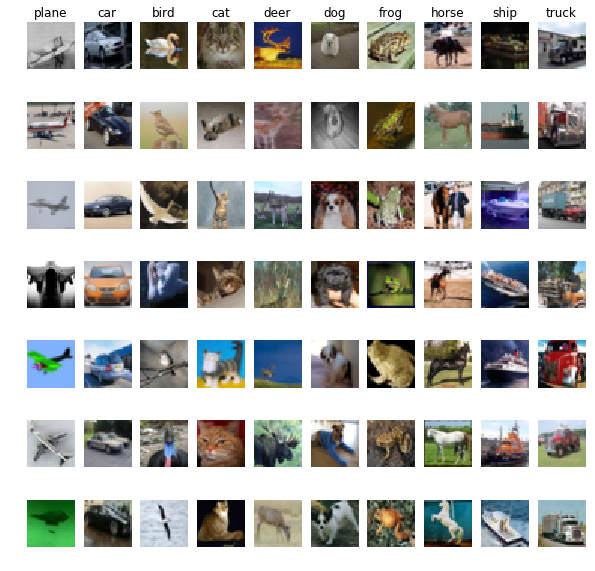

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 7
plt.figure(figsize=(10,10))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Each label vector row contains an integer (from 0 to 9) which categorises the class of the image. For image classification, we need to convert this to a binary matrix where each column indicates that the image belongs to a particular class.

In [6]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('Training labels shape: ', y_train.shape)
print('Testing labels shape: ', y_test.shape)

Training labels shape:  (50000, 10)
Testing labels shape:  (10000, 10)


Now we pre-process the testing and training data y performing mean subtraction. Geometrically this centers the data around the origin along each dimension. Note that we save the mean of the training data to apply that to the testing data.

Normally normalisation would be performed to ensure that the scale of each feature is approximately equal. This ensures that each feature is approximately of equal importance to the learning algorithm. In the case of images, we know that each feature (pixel) are already in the same scale (0 to 255) so this step is not necessary. 

In [7]:
# perform mean subtraction
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_mean = np.mean(X_train, axis = 0)
X_train -= X_mean
X_test -= X_mean
X_train /= 255
X_test /= 255

## The Model

Let's start by defining the CNN model. We use four convolution layers with ReLU activations, inserting max pooling layers intermittently. 

In [8]:
from keras import models
from keras.layers import Conv2D, Dropout, MaxPooling2D, Activation, Flatten, Dense 
from keras.constraints import maxnorm

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
__________

We configure an image data generator to perform data augmentation on our training set. This is to reduce the chance of overfitting given that the model has a large number of parameters.

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD

batch_size=64
epochs = 50
lrate = 0.01

# data augmentation
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')
datagen.fit(X_train)

# configure callbacks
filepath = os.path.join('models', 'cifar10-cnn-6layer-epoch:{epoch:02d}-val_acc:{val_acc:.2f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
callbacks = [checkpoint, early]

sgd = SGD(lr=lrate, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train) // batch_size,
                              epochs=epochs,
                              validation_data=(X_test, y_test),
                              callbacks=callbacks,
                              verbose=2)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

Epoch 1/50
 - 21s - loss: 1.5165 - acc: 0.4508 - val_loss: 1.3450 - val_acc: 0.5161
Epoch 2/50
 - 20s - loss: 1.3931 - acc: 0.4962 - val_loss: 1.1849 - val_acc: 0.5771
Epoch 3/50
 - 20s - loss: 1.3108 - acc: 0.5261 - val_loss: 1.0954 - val_acc: 0.6043
Epoch 4/50
 - 20s - loss: 1.2420 - acc: 0.5534 - val_loss: 1.0179 - val_acc: 0.6386
Epoch 5/50
 - 21s - loss: 1.1809 - acc: 0.5807 - val_loss: 1.0072 - val_acc: 0.6423
Epoch 6/50
 - 20s - loss: 1.1338 - acc: 0.5964 - val_loss: 0.8878 - val_acc: 0.6817
Epoch 7/50
 - 20s - loss: 1.0812 - acc: 0.6169 - val_loss: 0.8815 - val_acc: 0.6908
Epoch 8/50
 - 20s - loss: 1.0399 - acc: 0.6307 - val_loss: 0.8532 - val_acc: 0.7038
Epoch 9/50
 - 21s - loss: 1.0098 - acc: 0.6437 - val_loss: 0.8349 - val_acc: 0.7115
Epoch 10/50
 - 20s - loss: 0.9795 - acc: 0.6542 - val_loss: 0.7959 - val_acc: 0.7264
Epoch 11/50
 - 20s - loss: 0.9580 - acc: 0.6615 - val_loss: 0.7530 - val_acc: 0.7384
Epoch 12/50
 - 20s - loss: 0.9322 - acc: 0.6698 - val_loss: 0.8030 - val_a

The model produces an accuracy of 83% on the test set

## Analysis

First let's plot the loss and accuracy.

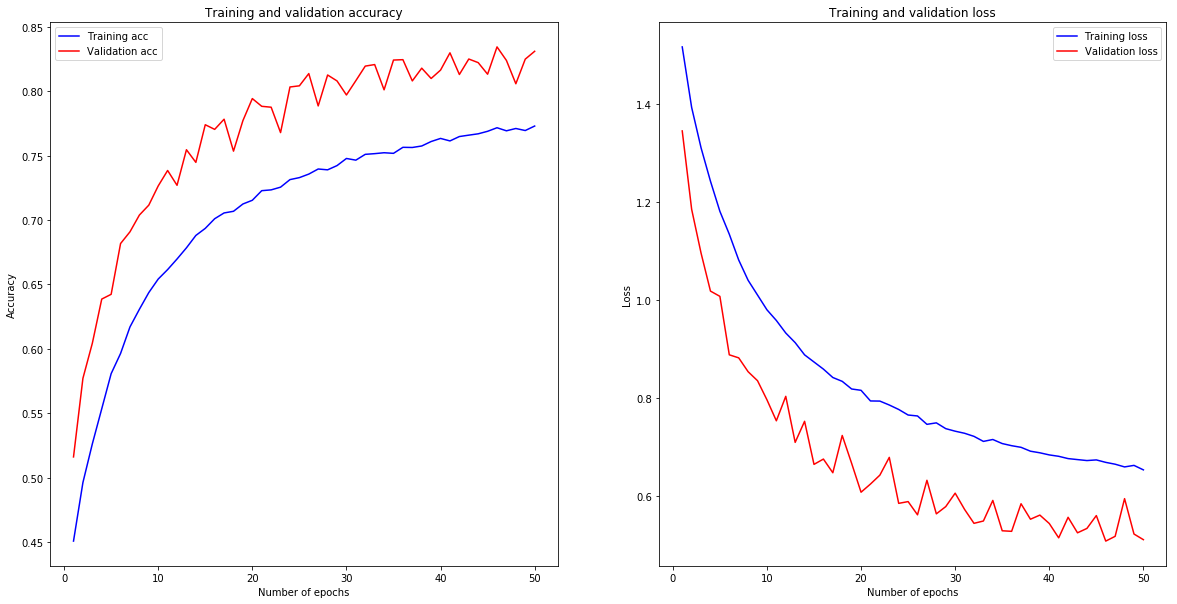

In [11]:
ys = range(1, epochs + 1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(ys, history.history['acc'], 'b-', label='Training acc')
ax1.plot(ys, history.history['val_acc'], 'r-', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(ys, history.history['loss'], 'b-', label='Training loss')
ax2.plot(ys, history.history['val_loss'], 'r-', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

We can see that the validation accuracy is higher than the training accuracy. This is attributed to dropout which occurs on the forward pass and degrades the performance of the network